# Códigos

## Código MMG-EM (MMG_EM.py)

In [ ]:
#%% LIBRERIAS
import numpy as np
from scipy import stats
#%% #cluster
def maxin(xx):
    maxi=xx==max(xx)
    maxs=np.sum(maxi)
    if maxs==1: a=xx.argmax()
    else: a=np.random.choice(np.where(xx==max(xx))[0])
    return(int(a))
#%%  mean and cov for cluster k
def parameters(X,mat,k,m):
    lxb=[]
    ls=[]
    c=0
    n,_=X.shape
    if m>=1:
        for i in range(k):
            var=i
            zer=mat[:,k]==var
            xb=np.mean(X[zer,:],0)
            s=np.cov(X[zer,:].T,bias=True)
            snans=np.sum(np.isnan(s))
            sinfs=np.sum(np.isinf(s))
            xbnans=np.sum(np.isnan(xb))
            xbinfs=np.sum(np.isinf(xb))
            u, ss, vh = np.linalg.svd(s)
            if (min(ss)<=1.0e-5) or (snans!=0 or sinfs!=0) or (xbnans!=0 or xbinfs!=0):
                c+=1
            lxb.append(xb)
            ls.append(s)
            
    else:
        for i in range(k):
            ks=np.arange(0,n)
            cc=np.random.choice(ks,1)
            xb=X[cc,:][0]
            s=np.cov(X.T,bias=True)
            snans=np.sum(np.isnan(s))
            sinfs=np.sum(np.isinf(s))
            xbnans=np.sum(np.isnan(xb))
            xbinfs=np.sum(np.isinf(xb))
            u, ss, vh = np.linalg.svd(s)
            if (min(ss)<=1.0e-5) or (snans!=0 or sinfs!=0) or (xbnans!=0 or xbinfs!=0):
                c+=1
            lxb.append(xb)
            ls.append(s)
    return(lxb,ls,c)
#%% Multivariate normal 
def gauM(x,xb,s):
    p=stats.multivariate_normal.pdf(x,mean=xb,cov=s)
    if (p<=0):
        p=0.001
    if (p>=1):
        p=0.999
    return(p)
#%% log-likelihood (ec 12.54)
def loglikel(mat_w,pim,l_xb,l_s,X_ob,k):
    n,_=X_ob.shape
    tl=0
    for i in range(n):
        lk=0
        for j in range(k):
            lk+=mat_w[i,j]*np.log(pim[j]*gauM(X_ob[i,:],l_xb[j],l_s[j]))
        tl+=lk    
    return(tl)
#%% #responsabilidades (ec 12.56)
def xik_mism(pim,l_xb,l_s,X_ob,i,k):
    l=[]
    tc=0
    for j in range(k):
        c=pim[j]*gauM(X_ob[i,:],l_xb[j],l_s[j])
        l.append(c)
        tc+=c
    vxik=np.array(l)
    vxik=vxik/tc
    return(vxik)
#%% checa que los pesos esten entre 0-1
def chekpim(pim):
    for i in range(len(pim)):
        v=pim[i]
        if(v<=0):
            v=0.001
        if(v>=1):
            v=0.999
        pim[i]=v
    return(pim)
#%% MMG
def MMG(X,k,max_iter=2000,eps=0.005/100):
    #m=0
    n,_=X.shape
    mat=np.zeros((n,k+1))
    pim=np.ones(k+1,)
    
    v=(n/k)/n
    pim=pim*v
    pim=pim[0:k] 
    pim=chekpim(pim) #pesos
    l_xb,l_s,sin=parameters(X,mat,k,0) #mu,sigma, singularidad u otro problema
    
    #m+1
    llm=0
    llm1=eps+0.01
    dif=1
    itern=0
    while ( dif>=eps and itern<=max_iter):
        llm=llm1
        #E-step
        if sin==0: #si no hay matrices singulares o nan o inf
            for i in range(n): 
                xik=xik_mism(pim,l_xb,l_s,X,i,k)
                mat[i,0:k]=xik[:] #responsabilidades
                mat[i,k]=maxin(xik) #cluster
            
            #M-step
            pim=np.mean(mat,0)[0:k]
            pim=chekpim(pim) #pesos
            l_xb,l_s,sin=parameters(X,mat,k,1) #parameters
        
            llm1=loglikel(mat,pim,l_xb,l_s,X,k) #log-likelihood
            dif=abs((llm1-llm)/llm1)
        else: #si  hay matrices singulares o nan o inf
            v=(n/k)/n
            pim=pim*v
            pim=pim[0:k]
            pim=chekpim(pim) #pesos
            l_xb,l_s,sin=parameters(X,mat,k,0) #parameters
        itern+=1
        
    centers=np.array(l_xb)
    return(mat,centers)

## Código Kernel K-Means (KERNEL_K_MEANS.py)

In [ ]:
#%% LIBRERIAS
import numpy as np
#%% tercer elemento de la distancia
def ted(K,c,k):
    vt=(c==k)
    Nc=np.sum(vt)
    ind=np.where(vt==True)[0]
    kc=0
    for i in ind:
        kc+=np.sum(K[i,vt])
    return(Nc,kc,vt)
#%% distancias a cada cluster
def dist_p_c(K,c,i,k):
    n,_=K.shape
    dic=np.zeros(k,)
    for j in range(k):
        Nc,kc,vt=ted(K,c,j)
        ki=np.sum(K[i,vt])
        d=K[i,i]-(2*ki/Nc)+(kc/(Nc**2))
        dic[j]=d
    return(dic)
#%% inicia  clusters de forma aleatoria
def initM(n,k):
    mat=np.zeros((n,k+1))
    for i in range(n):
        mat[i,k]=minin(mat[i,0:k]) #cluster
    return(mat)
#%% # seleciona cluster mas cercano
def minin(xx):
    maxi=xx==min(xx)
    maxs=np.sum(maxi)
    if maxs==1: a=xx.argmin()
    else: a=np.random.choice(np.where(xx==min(xx))[0])
    return(int(a))
#%% kernels
def kernels(x,y,kernel='Gauss',alfa=1,c=0,d=2,teta=0):
    if kernel=='Gauss':
        k=np.exp(-1*(np.linalg.norm(x-y)**2)/(2*(alfa**2)))
    elif kernel=='Polynomial':
        k=((np.dot(x,y))+c)**d
    else: #Sigmoid
        k=np.tanh(c*(np.dot(x,y))+teta)
    return(k)
#%% matrix K
def Kmat(X,kernel='Gauss',alfa=1,c=0,d=2,teta=0):
    n,p=X.shape
    K=np.zeros((n,n))
    Y=X
    
    for i in range(n): #X
        for j in range(n): #Y
            k=kernels(X[i,:],Y[j,:],kernel,alfa,c,d,teta)
            K[i,j]=k
    return(K)
#%% KERNEL_KM
def KERNEL_KM(X,k=2,kernel='Gauss',alfa=1,c=0,d=2,teta=0,max_iter=2000,eps=0.005/100):
    #m=0
    n,_=X.shape
    mat=initM(n,k) #inicializa la matriz de similaridades y cluster aleatoriamente
    
    K=Kmat(X,kernel,alfa,c,d,teta) #matriz de kernel

    #m+1
    llm=0
    llm1=eps+0.01
    dif=1
    itern=0
    while ( dif>=eps and itern<=max_iter):
        llm=llm1
        for i in range(n):
            d=dist_p_c(K,mat[:,k],i,k)
            mat[i,0:k]=d[:] # similaridades
            mat[i,k]=minin(mat[i,0:k]) #cluster (minima distancia)
  
        llm1=mat[i,k] #cluster
        
        dif=np.linalg.norm(llm1-llm)/np.linalg.norm(llm1)
        itern+=1
    return(mat)

# Ejemplos

In [1]:
# librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

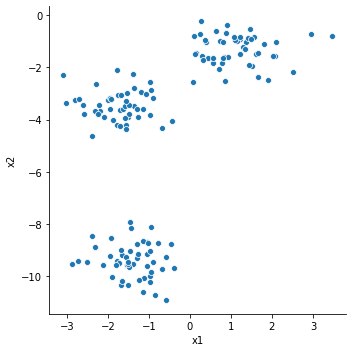

In [2]:
#%% DATOS

X, y = make_blobs(
   n_samples=150, n_features=2, centers=3, cluster_std=0.6, shuffle=True, random_state=2
)

data_toy = pd.DataFrame(X)
data_toy.columns = ['x1','x2']
data_toy = pd.DataFrame(data_toy).assign(cl = y)

custom_palette = ["red", "green", "blue"]
sns.relplot(x='x1', y='x2', data = data_toy)

## Kernel K-means

In [3]:
from KERNEL_K_MEANS import KERNEL_KM #libreria

In [4]:
mat=KERNEL_KM(X,k=3,kernel='Gauss',alfa=100) #ejecutando la función principal para kernel Gaussiano con sigma=100

In [5]:
matpol=KERNEL_KM(X,k=3,kernel='Polynomial',c=1000,d=2) 

In [6]:
matsig=KERNEL_KM(X,k=3,kernel='Sigmoid',c=-100,teta=(3/2)*3.1416/2) 

In [7]:
# Resultados a dataframe
data_toyg = pd.DataFrame(X)
data_toyg.columns = ['x1','x2']
data_toyg = pd.DataFrame(data_toyg).assign(cl = mat[:,3].astype(int))

data_toyp = pd.DataFrame(X)
data_toyp.columns = ['x1','x2']
data_toyp = pd.DataFrame(data_toyp).assign(cl = matpol[:,3].astype(int))

data_toys = pd.DataFrame(X)
data_toys.columns = ['x1','x2']
data_toys = pd.DataFrame(data_toys).assign(cl = matsig[:,3].astype(int))

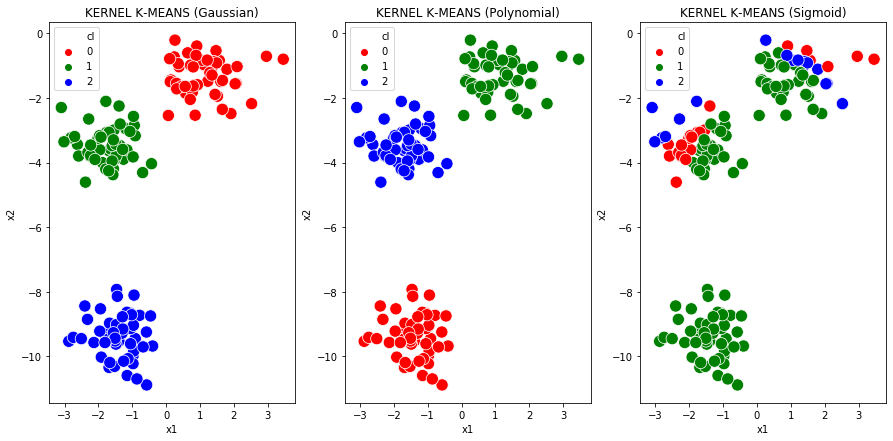

In [8]:
#Gráfico
fig = plt.figure(figsize=(15,7))
fig.add_subplot(131)
plt.title('KERNEL K-MEANS (Gaussian)')
sns.scatterplot(x='x1', y='x2', data = data_toyg, hue='cl', s=150, 
            palette = custom_palette,legend = 'brief')
fig.add_subplot(132)
plt.title('KERNEL K-MEANS (Polynomial)')
sns.scatterplot(x='x1', y='x2', hue = 'cl', data = data_toyp, palette=custom_palette, s=150)
fig.add_subplot(133)
plt.title('KERNEL K-MEANS (Sigmoid)')
sns.scatterplot(x='x1', y='x2', hue = 'cl', data = data_toys, palette=custom_palette, s=150)

# MMG-EM

In [9]:
from MMG_EM import MMG #libreria

In [10]:
matMMG,centersMMG=MMG(X,k=3) #ejecutando la función principal
data_toyMMG = pd.DataFrame(X) # Resultados a dataframe
data_toyMMG.columns = ['x1','x2']
data_toyMMG = pd.DataFrame(data_toyMMG).assign(cl = matMMG[:,3].astype(int))

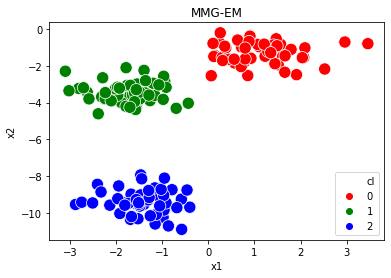

In [12]:
#Gráfico
plt.title('MMG-EM')
sns.scatterplot(x='x1', y='x2', data = data_toyMMG, hue='cl', s=150, 
            palette = custom_palette,legend = 'brief')